In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

from utils.subspace_clustering_helper_funcs import *
from utils.ae_eval_and_vis import *
from utils.ae_torch_classes import *
from utils.ml_pipeline import *

In [3]:
import warnings
warnings.filterwarnings('ignore')
# C:\Users\kdmen\miniconda3\envs\fl_torch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning warnings.warn(

# Load in Data

In [4]:
# Kai's laptop
data_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\PCA_40D\\"
#metadata_cols_df = pd.read_pickle('C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\metadata_cols_df.pkl')
# BRC Desktop
#data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\PCA_40D\\"
#metadata_cols_df = pd.read_pickle('metadata_cols_df.pkl')

print("Loading")

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']

full_pca40_train_XY_df = pd.read_pickle(data_path+'training_u_df.pkl')
full_pca40_test_XY_df = pd.read_pickle(data_path+'test_users_df.pkl')
full_pca40_gesture_train_labels_df = full_pca40_train_XY_df['Gesture_ID']
full_pca40_gesture_test_labels_df = full_pca40_test_XY_df['Gesture_ID']
full_pca40_user_train_labels_df = full_pca40_train_XY_df['Participant']
full_pca40_user_test_labels_df = full_pca40_test_XY_df['Participant']
full_pca40_training_u_df = full_pca40_train_XY_df.drop(metadata_cols, axis=1)
full_pca40_test_users_df = full_pca40_test_XY_df.drop(metadata_cols, axis=1)


Loading


One-hot encode the gestures so they can be used as labels. Should probably also do this for participant ID to use as a different label set but I'll do it later

In [5]:
# Get list of all the unique gesture names
all_train_test_gestures_df = pd.concat([full_pca40_gesture_train_labels_df, full_pca40_gesture_test_labels_df], axis=0)
unique_gestures = all_train_test_gestures_df.unique()

# Create OneHotEncoder instance
gesture_encoder = OneHotEncoder(sparse=False)
gesture_labels_reshaped = unique_gestures.reshape(-1, 1)
gesture_encoded = gesture_encoder.fit_transform(gesture_labels_reshaped)

In [6]:
print(full_pca40_train_XY_df.shape)
full_pca40_train_XY_df.head()

(327168, 43)


,Participant,Gesture_ID,Gesture_Num,0,1,2,3,4,5,6,...,30,31,32,33,34,35,36,37,38,39
0,P102,pan,1,-0.027903,0.001411,-0.019509,0.013428,-0.019699,0.027333,-0.031254,...,-0.019453,0.062983,-0.025869,0.014303,-0.013387,-0.037645,-0.186270,-0.046251,-0.104630,-0.002939
1,P102,pan,1,-0.038982,0.006470,-0.000111,0.010904,-0.015323,0.031336,-0.007901,...,0.041438,0.035053,-0.056843,-0.008895,-0.022542,-0.022563,-0.160826,-0.048161,-0.073771,0.043268
2,P102,pan,1,-0.116782,0.003824,0.011550,-0.014612,-0.093325,0.081718,-0.013155,...,-0.014298,0.072109,-0.026536,-0.034365,0.018695,-0.011940,-0.160580,-0.041831,-0.109653,0.027043
3,P102,pan,1,-0.030245,-0.017409,0.022540,-0.048905,-0.029129,0.090026,-0.024645,...,-0.010992,0.059990,-0.097073,-0.056870,-0.001038,-0.008015,-0.165858,-0.049424,-0.108671,0.069886
4,P102,pan,1,-0.112950,0.026262,0.004837,-0.063254,-0.108892,0.198729,-0.010583,...,0.035735,0.050880,-0.093678,-0.131263,0.018035,0.056185,-0.157963,-0.041911,-0.145308,0.063311


In [7]:
print(full_pca40_gesture_train_labels_df.shape)
full_pca40_gesture_train_labels_df.head()

(327168,)


0    pan
1    pan
2    pan
3    pan
4    pan
Name: Gesture_ID, dtype: object

In [8]:
print(full_pca40_training_u_df.shape)
full_pca40_training_u_df.head()

(327168, 40)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.027903,0.001411,-0.019509,0.013428,-0.019699,0.027333,-0.031254,-0.022910,0.066484,0.108729,...,-0.019453,0.062983,-0.025869,0.014303,-0.013387,-0.037645,-0.186270,-0.046251,-0.104630,-0.002939
1,-0.038982,0.006470,-0.000111,0.010904,-0.015323,0.031336,-0.007901,-0.027368,0.060370,0.074712,...,0.041438,0.035053,-0.056843,-0.008895,-0.022542,-0.022563,-0.160826,-0.048161,-0.073771,0.043268
2,-0.116782,0.003824,0.011550,-0.014612,-0.093325,0.081718,-0.013155,-0.046150,0.036385,0.052746,...,-0.014298,0.072109,-0.026536,-0.034365,0.018695,-0.011940,-0.160580,-0.041831,-0.109653,0.027043
3,-0.030245,-0.017409,0.022540,-0.048905,-0.029129,0.090026,-0.024645,-0.064307,0.074589,0.053055,...,-0.010992,0.059990,-0.097073,-0.056870,-0.001038,-0.008015,-0.165858,-0.049424,-0.108671,0.069886
4,-0.112950,0.026262,0.004837,-0.063254,-0.108892,0.198729,-0.010583,-0.124893,0.114817,0.038628,...,0.035735,0.050880,-0.093678,-0.131263,0.018035,0.056185,-0.157963,-0.041911,-0.145308,0.063311


In [9]:
# CREATE THE TRAINING SET
num_rows_per_gesture = 64 # From the interp
num_gestures = len(full_pca40_training_u_df) // num_rows_per_gesture
num_features = full_pca40_training_u_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(full_pca40_training_u_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns)
X_3D_PCA40 = full_pca40_training_u_df.to_numpy().reshape(num_gestures, num_rows_per_gesture, num_features)
#flattened_PCA = PCA_np.reshape(num_gestures, -1)

# Convert to PyTorch tensor
X_3DTensor_PCA40 = torch.tensor(X_3D_PCA40, dtype=torch.float32)

#################################################

# CREATE THE TEST SET
num_test_gestures = len(full_pca40_test_users_df) // num_rows_per_gesture
# Ensure the data can be evenly divided into gestures
assert len(full_pca40_test_users_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns) and convert to torch tensor
## Theres probably an easier way to just create it as a torch tensor lol
Xtest_3DTensor_PCA40 = torch.tensor(full_pca40_test_users_df.to_numpy().reshape(num_test_gestures, num_rows_per_gesture, num_features), dtype=torch.float32)

In [10]:
X_3DTensor_PCA40.shape

torch.Size([5112, 64, 40])

In [11]:
print(full_pca40_gesture_train_labels_df.shape)
full_pca40_gesture_train_labels_df.head()

(327168,)


0    pan
1    pan
2    pan
3    pan
4    pan
Name: Gesture_ID, dtype: object

In [12]:
label_per_gesture_df = full_pca40_gesture_train_labels_df.iloc[::64]
print(label_per_gesture_df.shape)
label_per_gesture_df.head()

(5112,)


0      pan
64     pan
128    pan
192    pan
256    pan
Name: Gesture_ID, dtype: object

In [13]:
full_pca40_train_XY_df[metadata_cols].iloc[::64].head()

,Participant,Gesture_ID,Gesture_Num
0,P102,pan,1
64,P102,pan,2
128,P102,pan,3
192,P102,pan,4
256,P102,pan,5


In [14]:
# Convert the DataFrame column to numpy array
labels_array = label_per_gesture_df.to_numpy()
# Create OneHotEncoder instance
gesture_encoder = OneHotEncoder(sparse=False)
# Reshape the labels array to fit the OneHotEncoder input shape
labels_reshaped = labels_array.reshape(-1, 1)
# Encode the labels
labels_encoded = gesture_encoder.fit_transform(labels_reshaped)
# Convert the encoded labels back to DataFrame
encoded_labels_df = pd.DataFrame(labels_encoded, columns=gesture_encoder.categories_[0])
print(encoded_labels_df.shape)
encoded_labels_df.head()

(5112, 28)


,air-tap,close,delete,double-clench,double-pinch,duplicate,frequency,gesture-1,gesture-2,gesture-3,...,point-and-pinch,range-of-motion,rotate,select-single,shake-and-release,single-clench,single-pinch,two-handed-tap,zoom-in,zoom-out
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Create the dataset obj
u_training_dataset = GestureDatasetClustering(X_3DTensor_PCA40, encoded_labels_df.to_numpy())
# Create the training dataloader
batch_size = 32  # Adjust batch size as needed
train_loader = DataLoader(u_training_dataset, batch_size=batch_size, shuffle=True) # Should shuffle be False? 
## It's shuffling the gesture order I think so that should be fine...

In [16]:
label_per_test_gesture_df = full_pca40_gesture_test_labels_df.iloc[::64]
gesture_encoder = OneHotEncoder(sparse=False)
test_labels_encoded = gesture_encoder.fit_transform(label_per_test_gesture_df.to_numpy().reshape(-1, 1))
encoded_test_labels_df = pd.DataFrame(test_labels_encoded, columns=gesture_encoder.categories_[0])

# Create the dataset obj
u_testing_dataset = GestureDatasetClustering(Xtest_3DTensor_PCA40, encoded_test_labels_df.to_numpy())
# Create the testing dataloader
test_loader = DataLoader(u_testing_dataset, batch_size=batch_size, shuffle=False)

In [17]:
# Function to check data types and shapes
def check_dataloader(loader):
    for i, (data, labels) in enumerate(loader):
        if not isinstance(data, torch.Tensor) or not isinstance(labels, torch.Tensor):
            print("Error: Data or labels are not tensors")
            break


In [18]:
# Check the DataLoader
check_dataloader(train_loader)

In [19]:
# Check the DataLoader
check_dataloader(test_loader)

In [20]:
# Create an iterator from the DataLoader
test_loader_iter = iter(test_loader)

# Get the first batch
first_batch = next(test_loader_iter)

# Unpack the data and labels
data, labels = first_batch

print("Data type:", type(data))
print("Data shape:", data.shape)
print("Labels type:", type(labels))
print("Labels shape:", labels.shape)

Data type: <class 'torch.Tensor'>
Data shape: torch.Size([32, 64, 40])
Labels type: <class 'torch.Tensor'>
Labels shape: torch.Size([32, 28])


## Load in and set up all saved models

In [21]:
# Kai:
model_dir_path = 'C:\\Users\\kdmen\\Desktop\\Research\\Repos\\fl-gestures\\models\\'
# BRC:
#model_dir_path = 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\'
timesteps = 64
seq_len = 64
num_features = 40
input_dim = 40

In [22]:
hidden_dim = 128
num_layers = 2
progressive = False
RNNAE_gridsearch_latent128_BothPCA40_model = RNNAutoencoder(input_dim, hidden_dim, num_layers, seq_len, progressive)

RNNAE_gridsearch_latent128_BothPCA40_model.load_state_dict(torch.load(model_dir_path+'RNNAE_latent128_progFalse_numlayers2_trial13_vallossp001_BothPCA40.pth'))

<All keys matched successfully>

In [23]:
for batch, _ in test_loader:
    print(f"Batch shape: {batch.shape}")  # Should print (32, 64, 40)
    batch, _ = next(iter(test_loader))
    latent = RNNAE_gridsearch_latent128_BothPCA40_model.encode(batch)
    print(f"Latent shape: {latent.shape}")
    break

Batch shape: torch.Size([32, 64, 40])
Latent shape: torch.Size([32, 64, 128])


Average testing loss across the entire test_loader: 0.0017131721086079037


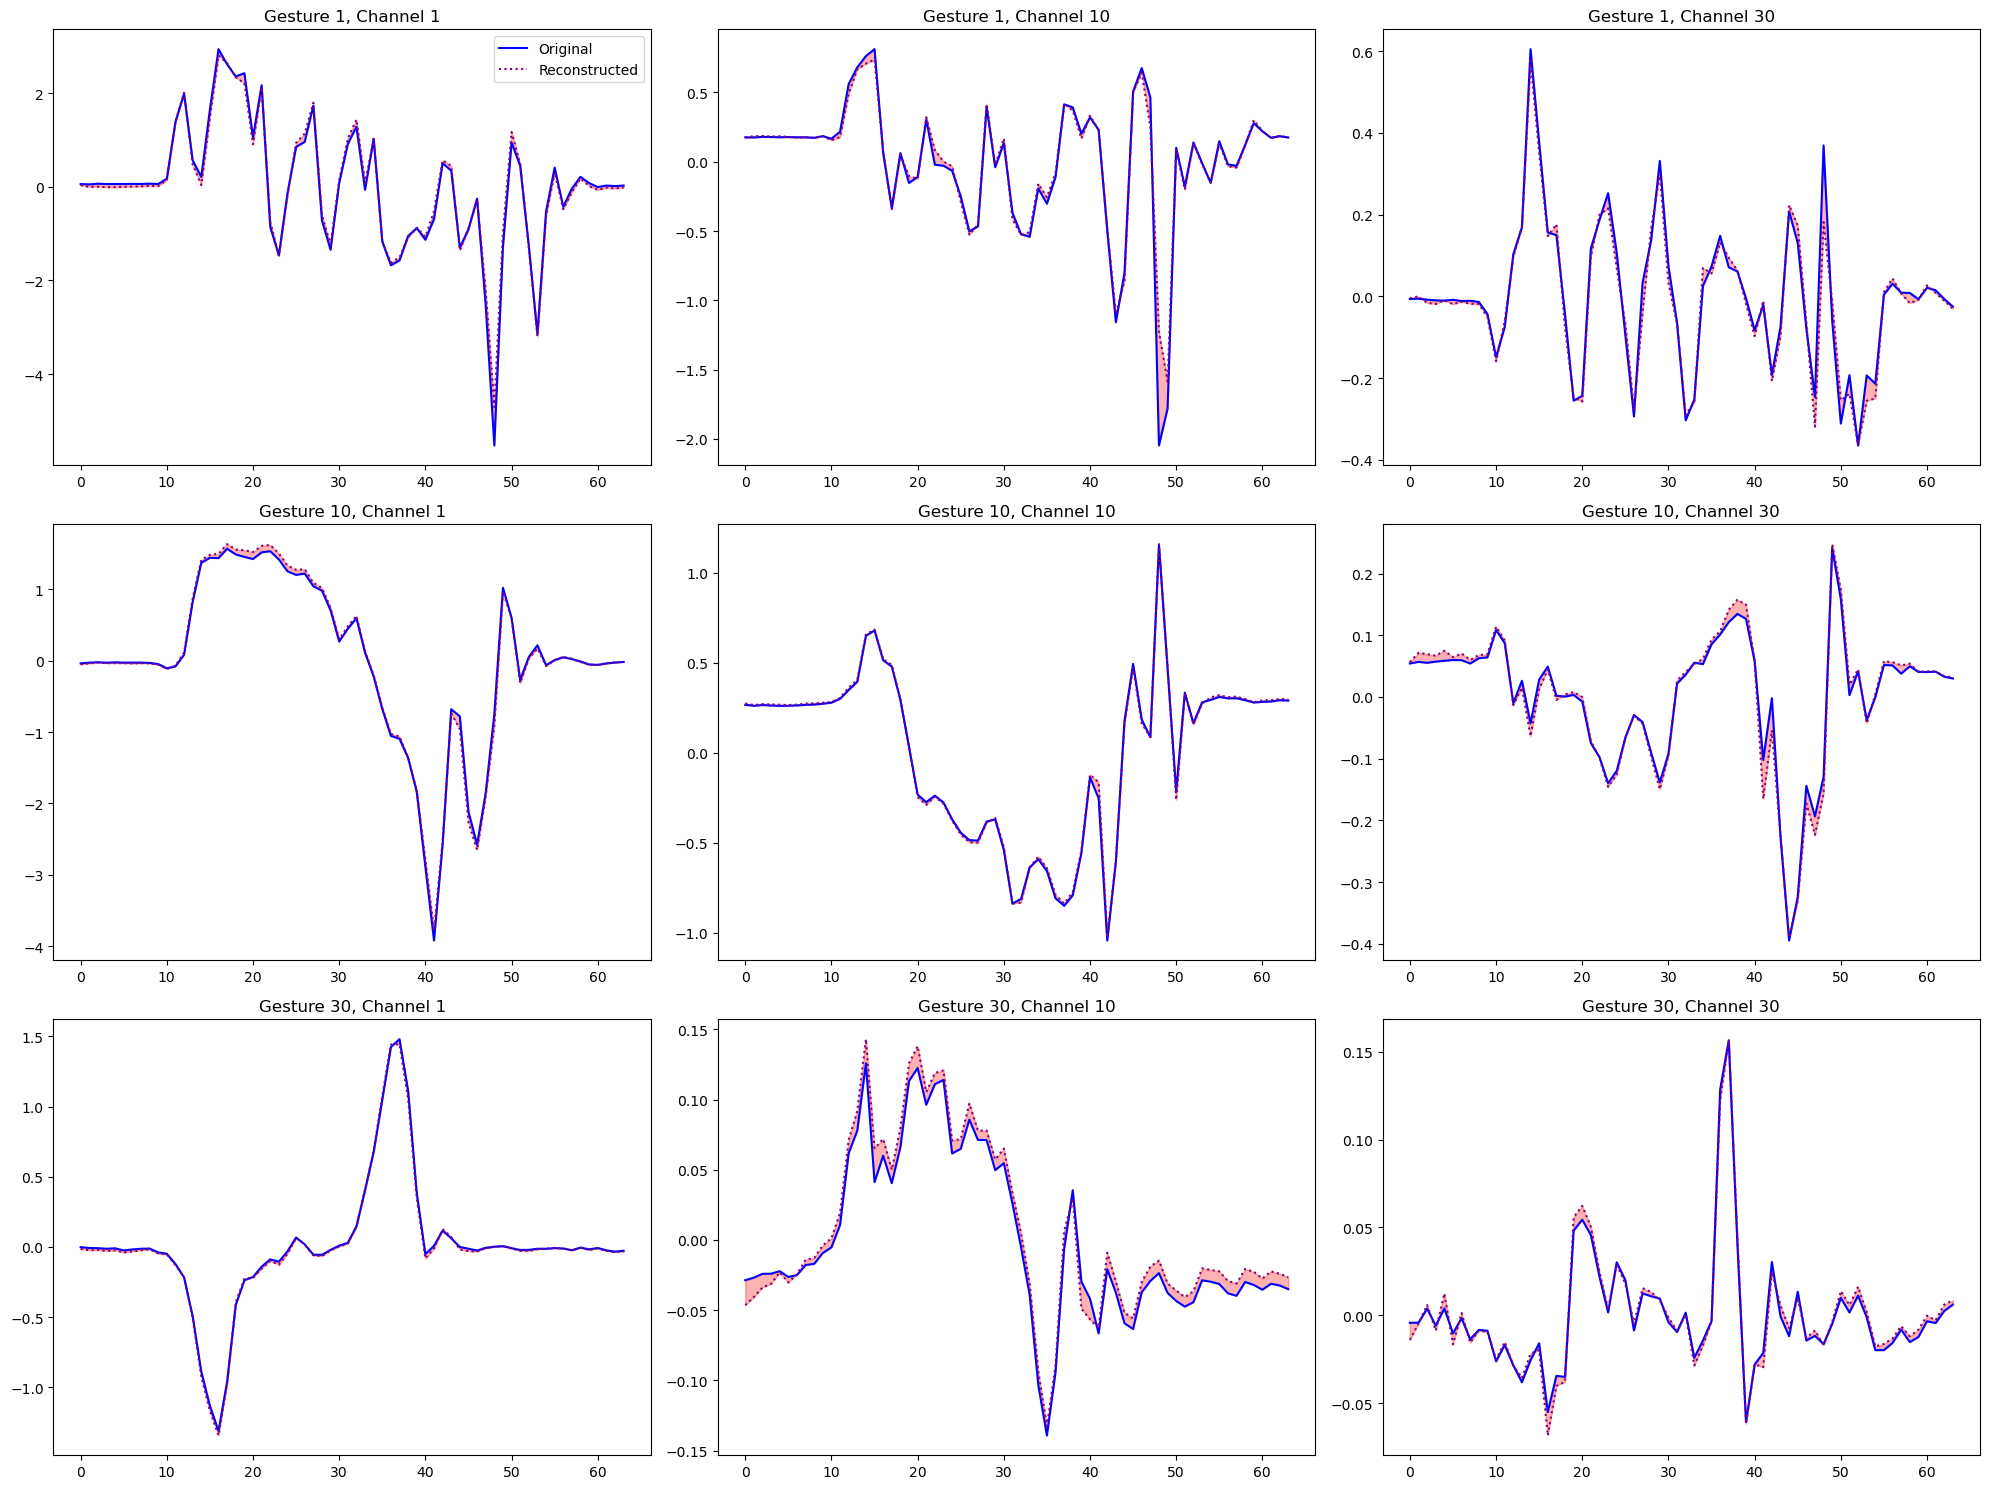

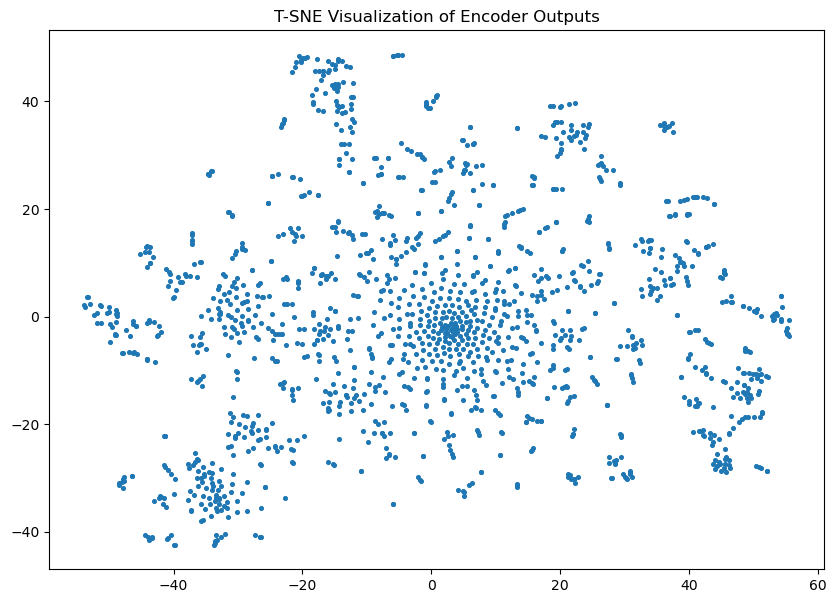

Explained variance by each principal component: [0.07483009 0.04933488]
Total explained variance: 0.1242


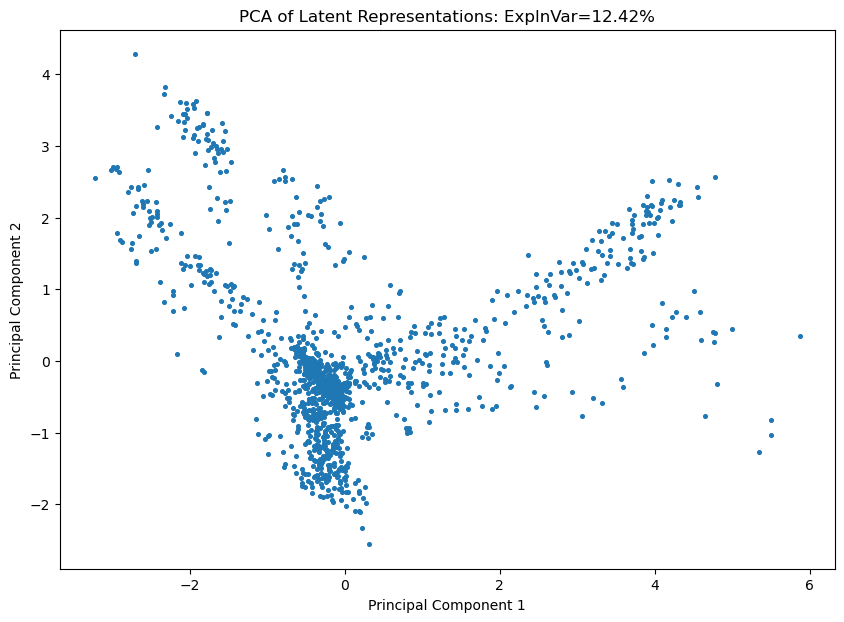

In [24]:
my_model = RNNAE_gridsearch_latent128_BothPCA40_model

average_test_loss, sample_data_lst, reconstructions_lst, latent_representations_lst = eval_on_testset_and_return_original_and_reconstructed(my_model, test_loader, xy_testloader=True)
visualize_original_vs_reconstructed_gestures(sample_data_lst[0], reconstructions_lst[0])
latent_space_vis(latent_representations_lst)

In [25]:
len(latent_representations_lst)
latent_representations = np.concatenate(latent_representations_lst)
print(latent_representations.shape)
# Reshape to 2D since TSNE and such can't handle 3D inputs...
latent128_BothPCA40 = latent_representations.reshape(latent_representations.shape[0], -1)
print(latent128_BothPCA40.shape)

(1556, 64, 128)
(1556, 8192)


In [26]:
hidden_dim = [32, 16, 3]
num_layers = None
RNNAE_32_16_3mir_BothPCA40_model = RNNAutoencoder(input_dim, hidden_dim, num_layers, seq_len, mirror=True)
RNNAE_32_16_3mir_BothPCA40_model.load_state_dict(torch.load(model_dir_path+'RNNAE_32_16_3mir_vallossp084_BothPCA40.pth'))

<All keys matched successfully>

Average testing loss across the entire test_loader: 0.08470256895311556


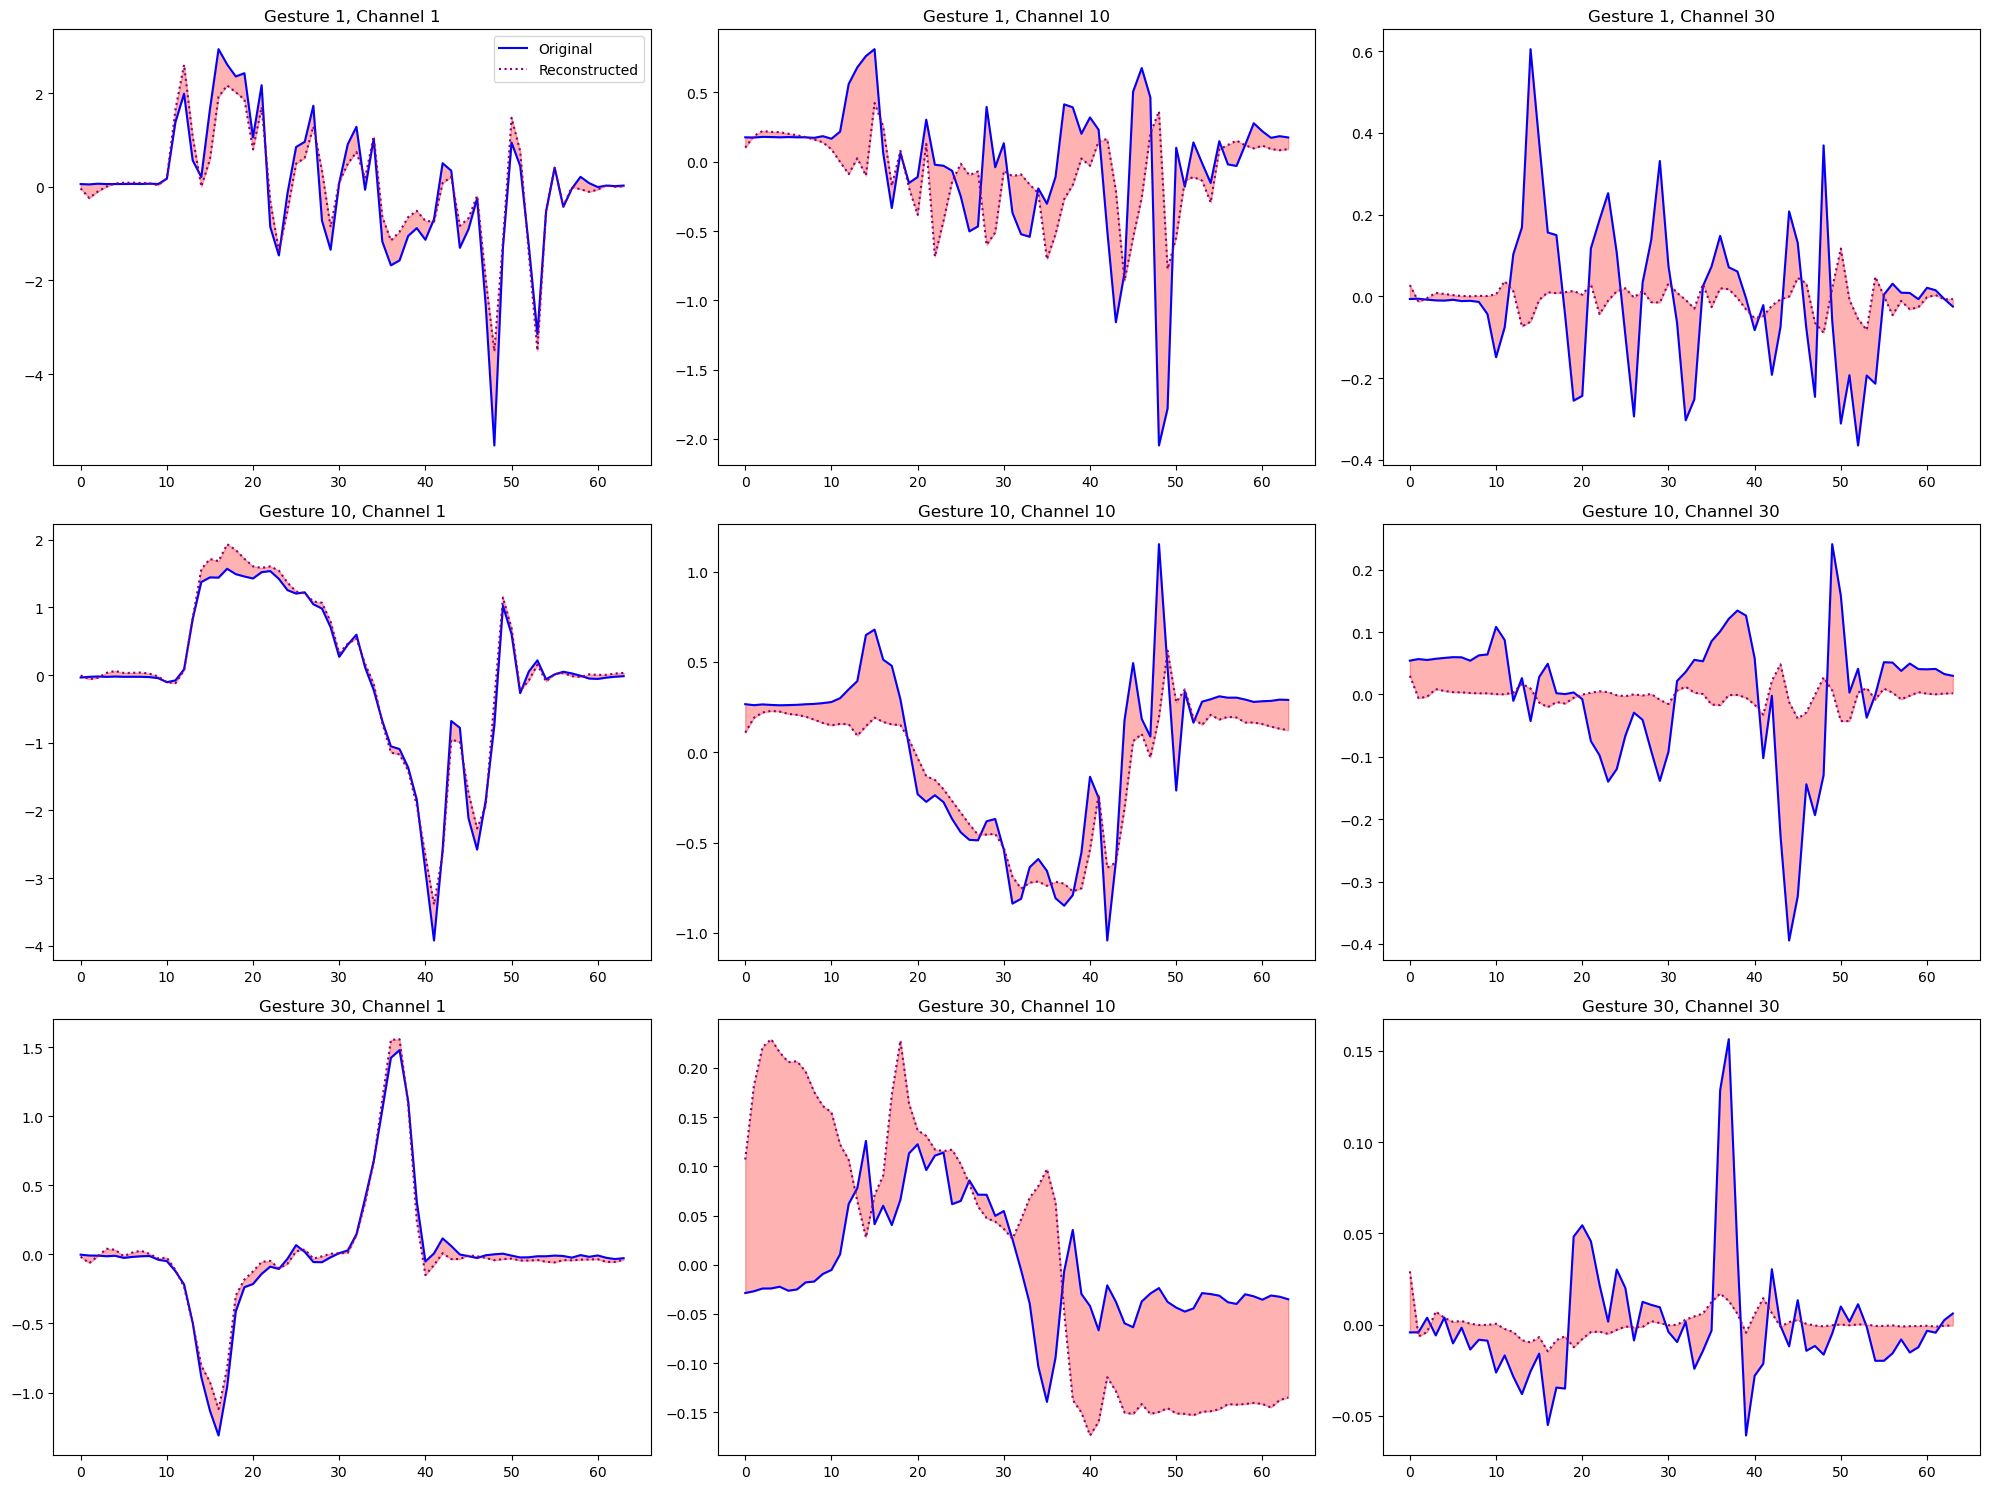

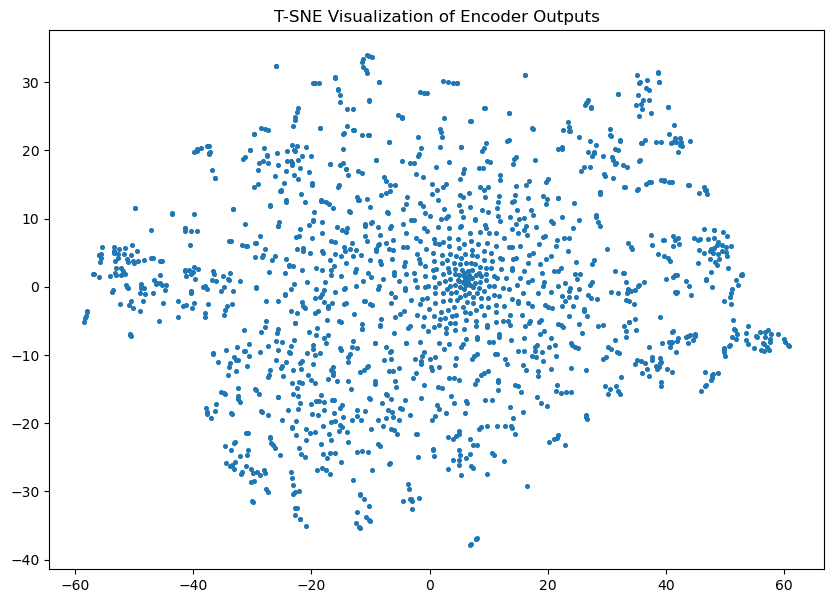

Explained variance by each principal component: [0.11831453 0.04932298]
Total explained variance: 0.1676


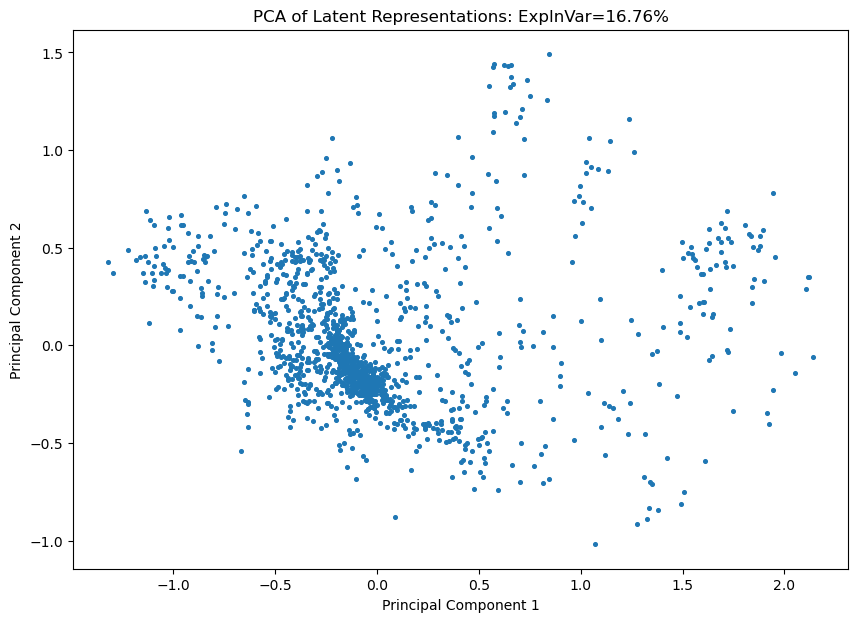

In [27]:
my_model = RNNAE_32_16_3mir_BothPCA40_model

average_test_loss, sample_data_lst, reconstructions_lst, latent_representations_lst = eval_on_testset_and_return_original_and_reconstructed(my_model, test_loader, xy_testloader=True)
visualize_original_vs_reconstructed_gestures(sample_data_lst[0], reconstructions_lst[0])
latent_space_vis(latent_representations_lst)

In [28]:
len(latent_representations_lst)

latent_representations = np.concatenate(latent_representations_lst)
print(latent_representations.shape)

# Reshape to 2D since TSNE and such can't handle 3D inputs...
latent3mir_BothPCA40 = latent_representations.reshape(latent_representations.shape[0], -1)
print(latent3mir_BothPCA40.shape)

(1556, 64, 3)
(1556, 192)


The above seems wrong, since if the latent space is 3D (since the bottleneck layer has 3 hidden nodes), then when it does PCA on that 3D representation (and it is doing PCA with n=3), it should be way higher explained variance right? Not sure why these is a massive discrepancy

In [29]:
hidden_dim = [56, 28]
num_layers = None
RNNAE_56_28mir_BothPCA40_model = RNNAutoencoder(input_dim, hidden_dim, num_layers, seq_len, mirror=True)
RNNAE_56_28mir_BothPCA40_model.load_state_dict(torch.load(model_dir_path+'RNNAE_56_28mir_vallossp013_BothPCA40.pth'))

<All keys matched successfully>

Average testing loss across the entire test_loader: 0.012865455203739527


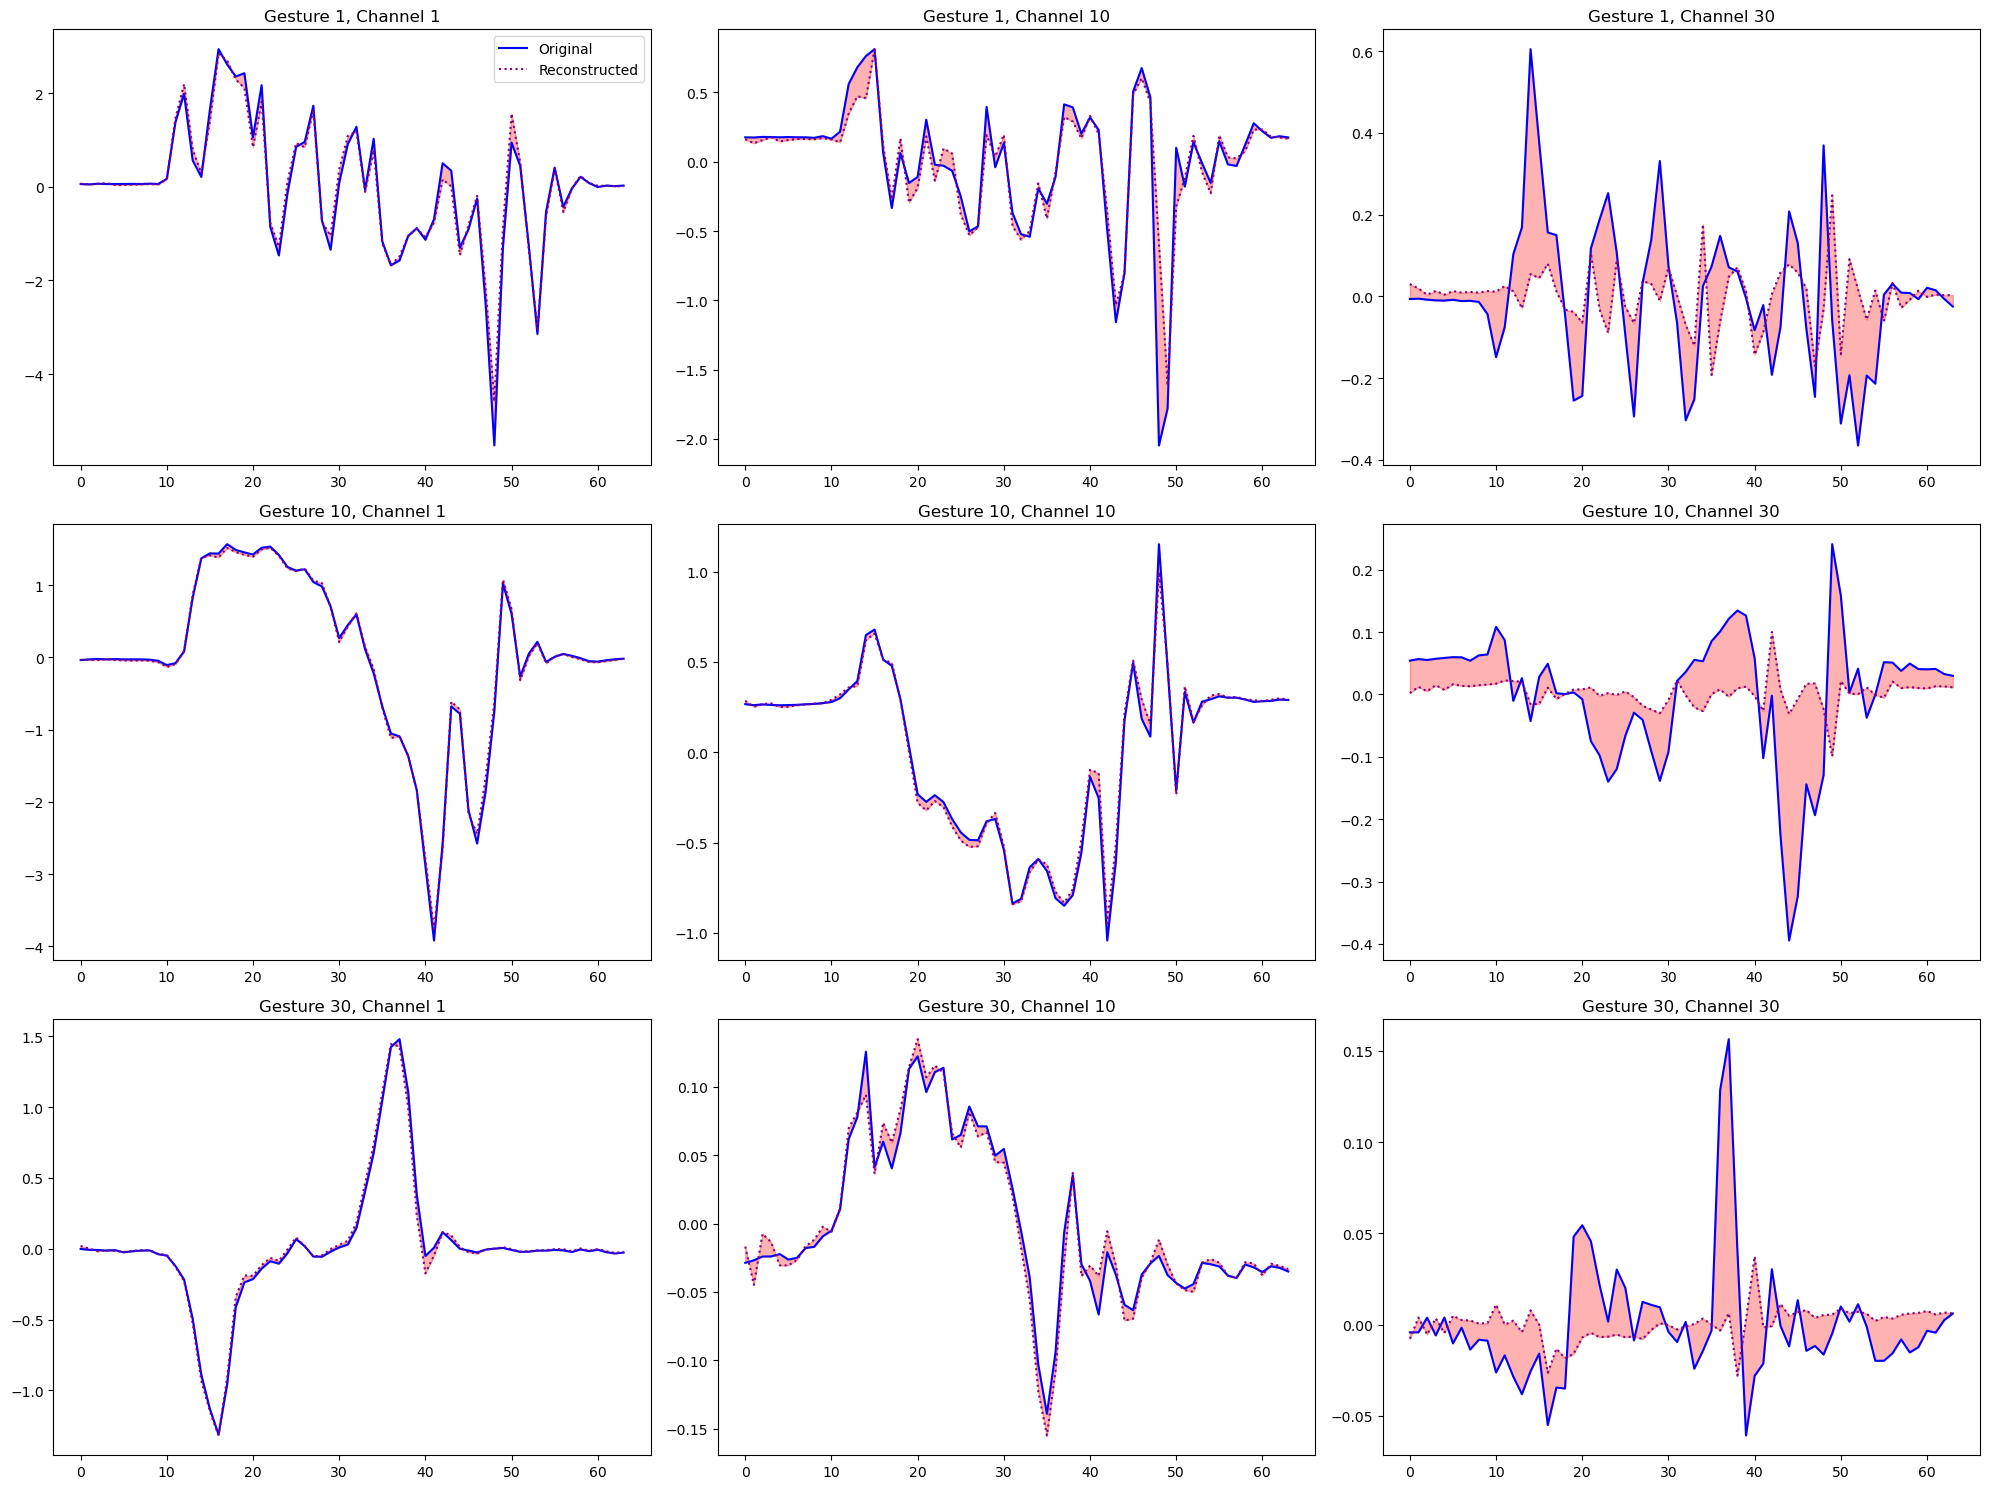

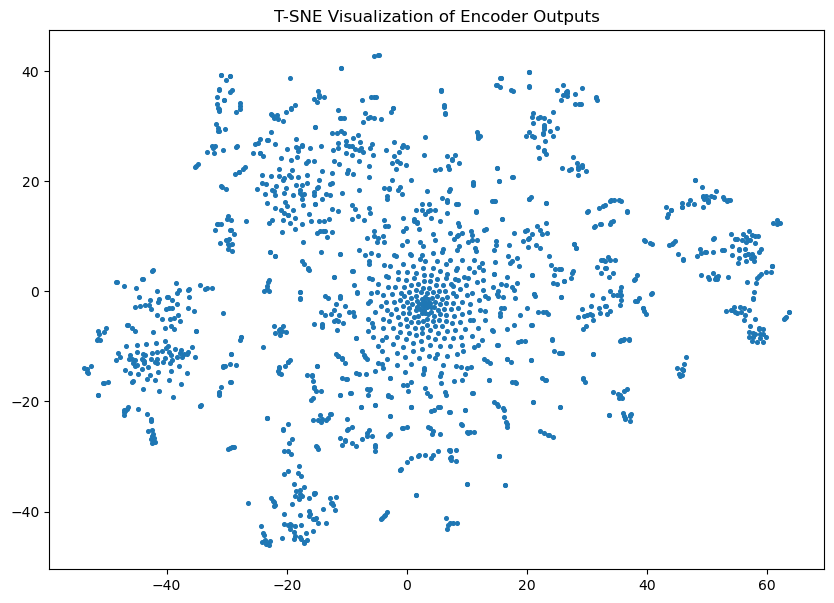

Explained variance by each principal component: [0.08604773 0.04720407]
Total explained variance: 0.1333


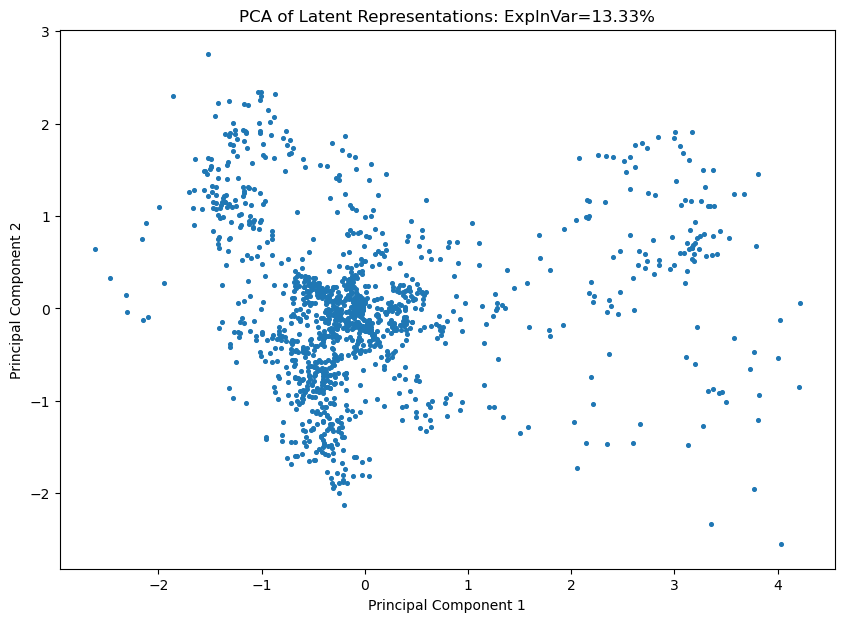

In [30]:
my_model = RNNAE_56_28mir_BothPCA40_model

average_test_loss, sample_data_lst, reconstructions_lst, latent_representations_lst = eval_on_testset_and_return_original_and_reconstructed(my_model, test_loader, xy_testloader=True)
visualize_original_vs_reconstructed_gestures(sample_data_lst[0], reconstructions_lst[0])
latent_space_vis(latent_representations_lst)

In [31]:
len(latent_representations_lst)

latent_representations = np.concatenate(latent_representations_lst)
print(latent_representations.shape)

# Reshape to 2D since TSNE and such can't handle 3D inputs...
latent28mir_BothPCA40 = latent_representations.reshape(latent_representations.shape[0], -1)
print(latent28mir_BothPCA40.shape)

(1556, 64, 28)
(1556, 1792)


Latent Space Clustering

In [32]:
#if clustering_algo_str == 'KMeans':
#    model = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto') 
#elif clustering_algo_str == 'DBSCAN':
#    model = DBSCAN(eps=eps, min_samples=min_samples)
#
#labels = model.fit_predict(X)

In [33]:
X_train_embeddings = RNNAE_gridsearch_latent128_BothPCA40_model.encode(X_3DTensor_PCA40)
X_test_embeddings = RNNAE_gridsearch_latent128_BothPCA40_model.encode(Xtest_3DTensor_PCA40)

# Convert from tensors, and reshape to 2D for these sklearn methods
X_train_embeddings = X_train_embeddings.reshape(X_train_embeddings.shape[0], -1).detach().numpy()
X_test_embeddings = X_test_embeddings.reshape(X_test_embeddings.shape[0], -1).detach().numpy()

print(f"encoded_labels_df shape: {encoded_labels_df.shape}")
print(f"encoded_test_labels_df shape: {encoded_test_labels_df.shape}")
print(f"X_train_embeddings shape: {X_train_embeddings.shape}")
print(f"X_test_embeddings shape: {X_test_embeddings.shape}")

encoded_labels_df shape: (5112, 28)
encoded_test_labels_df shape: (1556, 28)
X_train_embeddings shape: (5112, 8192)
X_test_embeddings shape: (1556, 8192)


Training knn, just using the closest neighbor (k=1)

In [34]:
# Define and train the KNN classifier
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train_embeddings, encoded_labels_df)

# Predict on the test data
y_pred = knn1.predict(X_test_embeddings)

# Calculate accuracy
accuracy = accuracy_score(encoded_test_labels_df, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 10.93%


Training knn, k=10

In [35]:
# Define and train the KNN classifier
knn10 = KNeighborsClassifier(n_neighbors=10)
knn10.fit(X_train_embeddings, encoded_labels_df)

# Predict on the test data
y_pred = knn10.predict(X_test_embeddings)

# Calculate accuracy
accuracy = accuracy_score(encoded_test_labels_df, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 4.56%


Using the 32 16 3 AE:

In [36]:
X_train_embeddings = RNNAE_32_16_3mir_BothPCA40_model.encode(X_3DTensor_PCA40)
X_test_embeddings = RNNAE_32_16_3mir_BothPCA40_model.encode(Xtest_3DTensor_PCA40)

# Convert from tensors, and reshape to 2D for these sklearn methods
X_train_embeddings = X_train_embeddings.reshape(X_train_embeddings.shape[0], -1).detach().numpy()
X_test_embeddings = X_test_embeddings.reshape(X_test_embeddings.shape[0], -1).detach().numpy()

print(f"encoded_labels_df shape: {encoded_labels_df.shape}")
print(f"encoded_test_labels_df shape: {encoded_test_labels_df.shape}")
print(f"X_train_embeddings shape: {X_train_embeddings.shape}")
print(f"X_test_embeddings shape: {X_test_embeddings.shape}")

encoded_labels_df shape: (5112, 28)
encoded_test_labels_df shape: (1556, 28)
X_train_embeddings shape: (5112, 192)
X_test_embeddings shape: (1556, 192)


In [37]:
# Define and train the KNN classifier
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train_embeddings, encoded_labels_df)

# Predict on the test data
y_pred = knn1.predict(X_test_embeddings)

# Calculate accuracy
accuracy = accuracy_score(encoded_test_labels_df, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 8.74%


In [38]:
# Define and train the KNN classifier
knn10 = KNeighborsClassifier(n_neighbors=10)
knn10.fit(X_train_embeddings, encoded_labels_df)

# Predict on the test data
y_pred = knn10.predict(X_test_embeddings)

# Calculate accuracy
accuracy = accuracy_score(encoded_test_labels_df, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 1.41%


Using the 56 28 AE:

In [39]:
X_train_embeddings = RNNAE_56_28mir_BothPCA40_model.encode(X_3DTensor_PCA40)
X_test_embeddings = RNNAE_56_28mir_BothPCA40_model.encode(Xtest_3DTensor_PCA40)

# Convert from tensors, and reshape to 2D for these sklearn methods
X_train_embeddings = X_train_embeddings.reshape(X_train_embeddings.shape[0], -1).detach().numpy()
X_test_embeddings = X_test_embeddings.reshape(X_test_embeddings.shape[0], -1).detach().numpy()

print(f"encoded_labels_df shape: {encoded_labels_df.shape}")
print(f"encoded_test_labels_df shape: {encoded_test_labels_df.shape}")
print(f"X_train_embeddings shape: {X_train_embeddings.shape}")
print(f"X_test_embeddings shape: {X_test_embeddings.shape}")

encoded_labels_df shape: (5112, 28)
encoded_test_labels_df shape: (1556, 28)
X_train_embeddings shape: (5112, 1792)
X_test_embeddings shape: (1556, 1792)


In [40]:
# Define and train the KNN classifier
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train_embeddings, encoded_labels_df)

# Predict on the test data
y_pred = knn1.predict(X_test_embeddings)

# Calculate accuracy
accuracy = accuracy_score(encoded_test_labels_df, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 13.24%


In [41]:
# Define and train the KNN classifier
knn10 = KNeighborsClassifier(n_neighbors=10)
knn10.fit(X_train_embeddings, encoded_labels_df)

# Predict on the test data
y_pred = knn10.predict(X_test_embeddings)

# Calculate accuracy
accuracy = accuracy_score(encoded_test_labels_df, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 4.88%


Now training an SVC for each AE embedding:

In [ ]:
# Create an SVM classifier
svm_model = SVC(kernel='linear', C=1.0, random_state=42)  # You can change kernel to 'rbf', 'poly', etc.

# Train the SVM model
svm_model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))